<a href="https://colab.research.google.com/github/Melsonwang1/CVNL-assignment/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/Colab\ Notebooks/


'archive (4).zip'     Untitled				 Week01_IntroToPyTorch.ipynb
'Copy of CNN.ipynb'  'Untitled (1)'			 Week02_Exercises.ipynb
 hillclimbing.ipynb  'Untitled (2)'			 Week02_PyTorchII.ipynb
 idlmam.py	     'Untitled (3)'			 Week07_CNN_II_Exercise.ipynb
 __pycache__	     'Untitled (4)'
 RNN.ipynb	     'Week01_IntroToPyTorch (1).ipynb'


In [3]:
!unzip "/content/drive/MyDrive/Colab Notebooks/archive (4).zip" -d "/content/asl_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_

In [4]:
!ls /content/asl_dataset


ASL_Alphabet_Dataset


In [5]:
import torchvision
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torchvision.utils import make_grid
import torch.optim as optim

In [6]:
# Check training directory
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train

# Check testing directory
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test

A  B  C  D  del  E  F  G  H  I	J  K  L  M  N  nothing	O  P  Q  R  S  space  T  U  V  W  X  Y	Z
A_test.jpg  E_test.jpg	I_test.jpg  M_test.jpg	      P_test.jpg      S_test.jpg  W_test.jpg
B_test.jpg  F_test.jpg	J_test.jpg  nothing_test.jpg  Q_test.jpg      T_test.jpg  X_test.jpg
C_test.jpg  G_test.jpg	K_test.jpg  N_test.jpg	      R_test.jpg      U_test.jpg  Y_test.jpg
D_test.jpg  H_test.jpg	L_test.jpg  O_test.jpg	      space_test.jpg  V_test.jpg  Z_test.jpg


In [7]:
import os
import shutil

# Path to the test dataset
test_path = '/content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test'

# Reorganize test dataset into subfolders by class
for file in os.listdir(test_path):
    if file.endswith('.jpg'):
        # Extract the class name from the file name (e.g., 'a_test.jpg' -> 'a')
        class_name = file.split('_')[0].lower()
        class_dir = os.path.join(test_path, class_name)

        # Create a directory for the class if it doesn't already exist
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Move the file to the corresponding class directory
        shutil.move(os.path.join(test_path, file), os.path.join(class_dir, file))

In [8]:
# Check reorganized testing directory
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test

# Check a specific class in the test directory (e.g., 'a' class)
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test/a

a  b  c  d  e  f  g  h	i  j  k  l  m  n  nothing  o  p  q  r  s  space  t  u  v  w  x	y  z
A_test.jpg


In [9]:
# Check for CUDA device
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [11]:
from torch.utils.data import random_split
# Load datasets
train_dataset = datasets.ImageFolder('/content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train', transform=transforms)
test_dataset = datasets.ImageFolder('/content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test', transform=transforms)

# Define split sizes (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the training dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Print dataset sizes
print(f"New Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

New Training dataset size: 200766
Validation dataset size: 22308


In [12]:
# Define transformations: Resize, Convert to Tensor, Normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train', transform=transform)
test_dataset = datasets.ImageFolder('/content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_test', transform=transform)

# Create a subset of the training dataset
import random
from torch.utils.data import Subset

# Define the percentage of the training dataset to use
subset_percentage = 0.2  # Use 20% of the training dataset
num_subset_samples = int(subset_percentage * len(train_dataset))

# Set a seed for reproducibility
random.seed(42)
indices = random.sample(range(len(train_dataset)), num_subset_samples)

# Create the subset
train_subset = Subset(train_dataset, indices)

# Create data loaders for the subset
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Subset training dataset size: {len(train_subset)}")
print(f"Testing dataset size: {len(test_dataset)}")



Subset training dataset size: 44614
Testing dataset size: 28


In [17]:
class ASLCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(ASLCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # We'll calculate this dynamically
        self.flattened_size = None
        self.fc1 = None
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Dynamically compute flattened size
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flattened_size, 512).to(x.device)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Dynamic computation
        self.flattened_size = None
        self.fc1 = None
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        # Dynamically compute flattened size
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flattened_size, 512).to(x.device)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [19]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, criterion, optimizer, num_epochs=10):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix(loss=(running_loss / len(loader)))

        epoch_loss = running_loss / len(loader)
        epoch_accuracy = correct / total
        loss_history.append((epoch_loss, epoch_accuracy))
        print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

    return loss_history

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Train the model
train(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10: 100%|██████████| 698/698 [01:27<00:00,  8.01batch/s, loss=0.0954]


Epoch 1: Loss = 0.0954, Accuracy = 0.9693


Epoch 2/10: 100%|██████████| 698/698 [01:27<00:00,  7.98batch/s, loss=0.0891]


Epoch 2: Loss = 0.0891, Accuracy = 0.9717


Epoch 3/10: 100%|██████████| 698/698 [01:29<00:00,  7.77batch/s, loss=0.0878]


Epoch 3: Loss = 0.0878, Accuracy = 0.9717


Epoch 4/10: 100%|██████████| 698/698 [01:26<00:00,  8.04batch/s, loss=0.0721]


Epoch 4: Loss = 0.0721, Accuracy = 0.9766


Epoch 5/10: 100%|██████████| 698/698 [01:26<00:00,  8.03batch/s, loss=0.0681]


Epoch 5: Loss = 0.0681, Accuracy = 0.9774


Epoch 6/10: 100%|██████████| 698/698 [01:29<00:00,  7.83batch/s, loss=0.0692]


Epoch 6: Loss = 0.0692, Accuracy = 0.9778


Epoch 7/10: 100%|██████████| 698/698 [01:27<00:00,  7.96batch/s, loss=0.0626]


Epoch 7: Loss = 0.0626, Accuracy = 0.9797


Epoch 8/10: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=0.0611]


Epoch 8: Loss = 0.0611, Accuracy = 0.9799


Epoch 9/10: 100%|██████████| 698/698 [01:28<00:00,  7.85batch/s, loss=0.0552]


Epoch 9: Loss = 0.0552, Accuracy = 0.9829


Epoch 10/10: 100%|██████████| 698/698 [01:27<00:00,  7.98batch/s, loss=0.0558]

Epoch 10: Loss = 0.0558, Accuracy = 0.9825


[(0.09543281328366712, 0.9692921504460483),
 (0.0891349100581848, 0.9717129152284036),
 (0.08780029369151236, 0.9717353297171292),
 (0.07209142790470181, 0.9765768592818398),
 (0.06809300434993137, 0.9774061953646838),
 (0.06919610119534171, 0.977809656161743),
 (0.06263822997577641, 0.979737302192137),
 (0.06112874320252561, 0.9799166181019411),
 (0.05516476320275599, 0.9828529161249832),
 (0.05584445163820414, 0.9824718698166495)]

In [20]:
# Initialize models
cnn_with_pool = ASLCNN(num_classes=29).to(device)
simple_cnn = SimpleCNN(num_classes=29).to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer_with_pool = optim.Adam(cnn_with_pool.parameters(), lr=0.001)
optimizer_simple = optim.Adam(simple_cnn.parameters(), lr=0.001)

# Train models
history_with_pool = train(cnn_with_pool, train_loader, criterion, optimizer_with_pool, num_epochs=10)
history_simple = train(simple_cnn, train_loader, criterion, optimizer_simple, num_epochs=10)


Epoch 1/10: 100%|██████████| 698/698 [01:26<00:00,  8.09batch/s, loss=2.87]


Epoch 1: Loss = 2.8719, Accuracy = 0.1800


Epoch 2/10: 100%|██████████| 698/698 [01:27<00:00,  8.00batch/s, loss=2.43]


Epoch 2: Loss = 2.4347, Accuracy = 0.2880


Epoch 3/10: 100%|██████████| 698/698 [01:25<00:00,  8.13batch/s, loss=2.25]


Epoch 3: Loss = 2.2481, Accuracy = 0.3365


Epoch 4/10: 100%|██████████| 698/698 [01:26<00:00,  8.12batch/s, loss=2.11]


Epoch 4: Loss = 2.1106, Accuracy = 0.3747


Epoch 5/10: 100%|██████████| 698/698 [01:27<00:00,  7.95batch/s, loss=2]


Epoch 5: Loss = 2.0026, Accuracy = 0.4008


Epoch 6/10: 100%|██████████| 698/698 [01:25<00:00,  8.12batch/s, loss=1.93]


Epoch 6: Loss = 1.9283, Accuracy = 0.4209


Epoch 7/10: 100%|██████████| 698/698 [01:25<00:00,  8.18batch/s, loss=1.85]


Epoch 7: Loss = 1.8537, Accuracy = 0.4413


Epoch 8/10: 100%|██████████| 698/698 [01:25<00:00,  8.13batch/s, loss=1.79]


Epoch 8: Loss = 1.7898, Accuracy = 0.4619


Epoch 9/10: 100%|██████████| 698/698 [01:27<00:00,  8.00batch/s, loss=1.73]


Epoch 9: Loss = 1.7297, Accuracy = 0.4784


Epoch 10/10: 100%|██████████| 698/698 [01:26<00:00,  8.05batch/s, loss=1.67]


Epoch 10: Loss = 1.6733, Accuracy = 0.4923


Epoch 1/10: 100%|██████████| 698/698 [01:51<00:00,  6.28batch/s, loss=2.89]


Epoch 1: Loss = 2.8911, Accuracy = 0.1772


Epoch 2/10: 100%|██████████| 698/698 [01:48<00:00,  6.44batch/s, loss=2.51]


Epoch 2: Loss = 2.5089, Accuracy = 0.2716


Epoch 3/10: 100%|██████████| 698/698 [01:48<00:00,  6.41batch/s, loss=2.36]


Epoch 3: Loss = 2.3634, Accuracy = 0.3113


Epoch 4/10: 100%|██████████| 698/698 [01:48<00:00,  6.44batch/s, loss=2.26]


Epoch 4: Loss = 2.2563, Accuracy = 0.3373


Epoch 5/10: 100%|██████████| 698/698 [01:49<00:00,  6.39batch/s, loss=2.16]


Epoch 5: Loss = 2.1606, Accuracy = 0.3604


Epoch 6/10: 100%|██████████| 698/698 [01:48<00:00,  6.43batch/s, loss=2.09]


Epoch 6: Loss = 2.0895, Accuracy = 0.3762


Epoch 7/10: 100%|██████████| 698/698 [01:48<00:00,  6.42batch/s, loss=2.03]


Epoch 7: Loss = 2.0287, Accuracy = 0.3955


Epoch 8/10: 100%|██████████| 698/698 [01:48<00:00,  6.43batch/s, loss=1.96]


Epoch 8: Loss = 1.9598, Accuracy = 0.4104


Epoch 9/10: 100%|██████████| 698/698 [01:47<00:00,  6.49batch/s, loss=1.91]


Epoch 9: Loss = 1.9137, Accuracy = 0.4250


Epoch 10/10: 100%|██████████| 698/698 [01:50<00:00,  6.30batch/s, loss=1.86]

Epoch 10: Loss = 1.8621, Accuracy = 0.4401


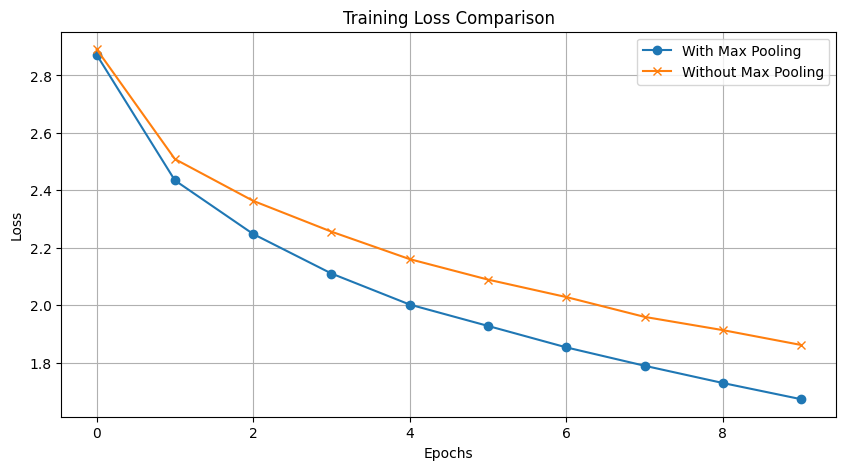

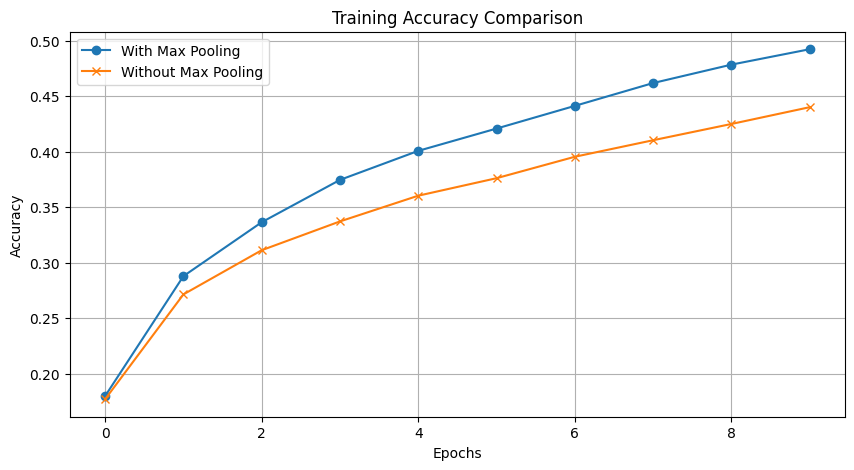

In [21]:
# Extract metrics
loss_with_pool, acc_with_pool = zip(*history_with_pool)
loss_simple, acc_simple = zip(*history_simple)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss_with_pool, label="With Max Pooling", marker='o')
plt.plot(loss_simple, label="Without Max Pooling", marker='x')
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc_with_pool, label="With Max Pooling", marker='o')
plt.plot(acc_simple, label="Without Max Pooling", marker='x')
plt.title("Training Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()